In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
#from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

%run '/CTE.ipynb'

torch.Size([1, 105])


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=2d57a3031e52a8a792661c9c565ffe3cbd13c221acb5491b1f803046b19a8197
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
import zipfile

def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


zip_file_path = '/Datasets for Interpretation.zip'
extract_to = '/content'

unzip_file(zip_file_path, extract_to)

In [ ]:
model_path = '/CTE_ICDAR19.pth'
model = GrnnNet(1,num_classes=511).to('cuda')

model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

<ipython-input-4-44e01d136137>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))


<All keys matched successfully>

In [ ]:
target_layers = [model.encoder_layer.vgg.conv4]
print(target_layers)

[Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)]


In [ ]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_VIRIDIS,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [ ]:
import os
import pickle
from PIL import Image
from scipy import misc
import torch.utils.data as data
import torch
from torchvision.transforms import Compose, ToTensor
import random


In [ ]:
scale_size=(64,128)
is_training = False

def transform():
  return Compose([ToTensor(),])

def resizing(image):
  w,h = image.size[:2]
  ratio_h = float(scale_size[0])/float(h)
  ratio_w = float(scale_size[1])/float(w)

  if ratio_h < ratio_w:
    ratio = ratio_h
    hfirst = False
  else:
    ratio = ratio_w
    hfirst = True


  nh = int(ratio * h)
  nw = int(ratio * w)

  imre = image.resize((nw, nh))
  #imre = misc.imresize(image,(nh,nw))
  im_array = np.array(imre)


  # Invert the image
  im_array = 255 - im_array
  imre = Image.fromarray(im_array)

  if imre is None:
      raise ValueError("The 'imre' variable is not defined.")

  if not isinstance(imre, Image.Image):
      raise TypeError("The 'imre' variable is not an image.")

  try:
    imre.verify()
  except Exception as e:
    raise ValueError("The image data in 'imre' is corrupted.") from e
    #imre = 255 - imre

  cw, ch = imre.size
  if is_training:
      new_img = np.zeros(scale_size)
      dy = int((scale_size[0]-ch))
      dx = int((scale_size[1]-cw))
      dy = random.randint(0,dy)
      dx = random.randint(0,dx)
  else:
      new_img = np.zeros(scale_size)
      dy = int((scale_size[0]-ch)/2.0)
      dx = int((scale_size[1]-cw)/2.0)

      #new_img = np.zeros(self.scale_size)
      #dy = int((self.scale_size[0]-ch)/2.0)
      #dx = int((self.scale_size[1]-cw)/2.0)

  imre = imre.convert('F')
  #imre = imre.astype('float')

  new_img[dy:dy+ch,dx:dx+cw] = imre
  #new_img /= 256.0
  #print(new_img.shape)

  return new_img


----------------------------------------------------
writer166&writer6
----------------------------------------------------
/content/Datasets for Interpretation/ICDAR19/writer166&writer6/Sample2_6_6_109_validation.png
/content/Datasets for Interpretation/ICDAR19/writer166&writer6/Sample1_166_941_97_validation.png


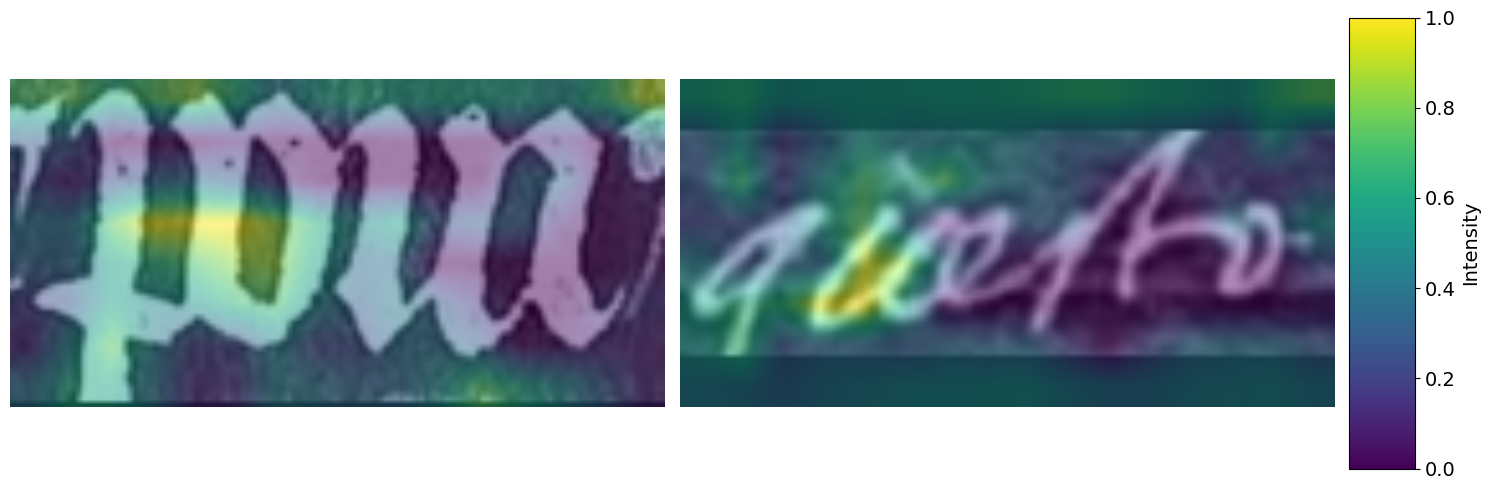

----------------------------------------------------
writer166
----------------------------------------------------
/content/Datasets for Interpretation/ICDAR19/writer166/Sample1_166_941_161_train.png
/content/Datasets for Interpretation/ICDAR19/writer166/Sample2_166_941_97_validation.png


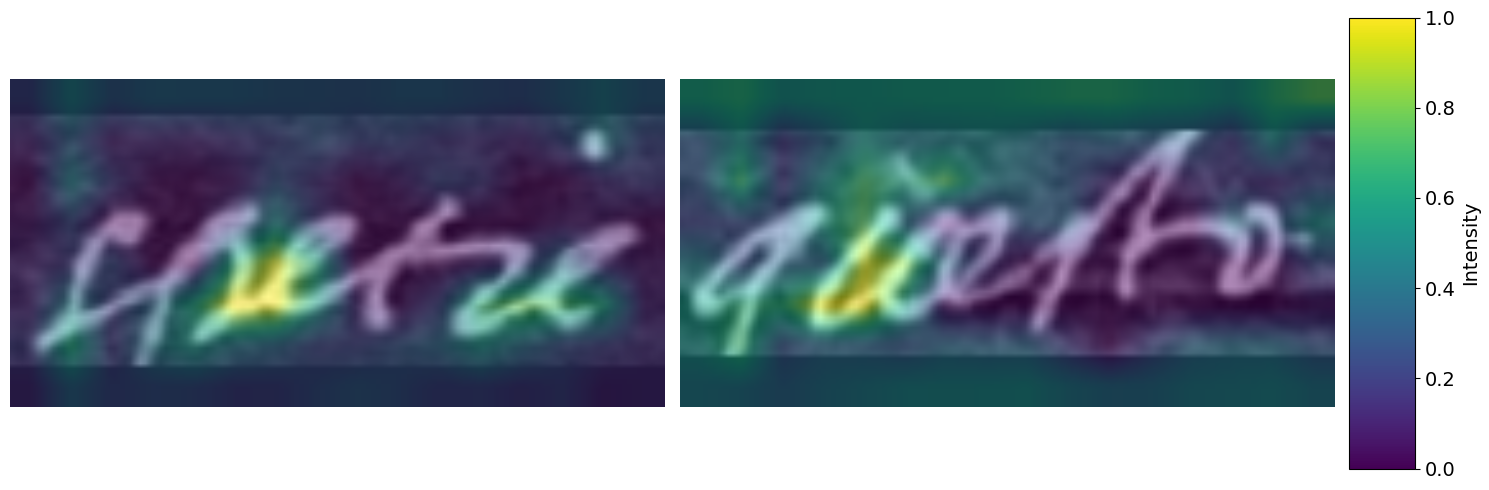

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image

path = "/content/Datasets for Interpretation/ICDAR19"


for folder_name in os.listdir(path):
    if folder_name != '.DS_Store':
        folder_path = os.path.join(path, folder_name)
        print("----------------------------------------------------")
        print(folder_name)
        print("----------------------------------------------------")


        visualizations = []

        for filename in os.listdir(folder_path):
            filepath = os.path.join(folder_path, filename)
            if os.path.isfile(filepath) and filepath.endswith('.png'):
                image = Image.open(filepath).convert('L')
                image = resizing(image)
                image = image / 255.0

                rgb_img = np.stack((image, image, image), axis=-1)
                img_tensor = transform()(image)
                img_tensor = img_tensor.float()

                cam = GradCAM(model=model, target_layers=target_layers)
                grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=None)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                visualizations.append(visualization)
                print(filepath)


        num_images = len(visualizations)
        fig = plt.figure(figsize=(15, 5))
        gs = gridspec.GridSpec(1, num_images + 1, width_ratios=[1] * num_images + [0.1])


        for i, vis in enumerate(visualizations):
            ax = fig.add_subplot(gs[i])
            im = ax.imshow(vis, interpolation='bilinear')
            ax.axis('off')
            im.set_clim(0, 1)


        ax_cbar = fig.add_subplot(gs[-1])
        cbar = plt.colorbar(im, cax=ax_cbar, pad=0.1)
        cbar.ax.set_ylabel('Intensity', fontsize=14)

        cbar.ax.tick_params(labelsize=14)


        plt.subplots_adjust(wspace=0.3)

        plt.tight_layout()


        plt.savefig(f"{folder_name}_visualization.png", format='png', dpi=300)

        plt.show()


In [ ]:
import os
import shutil

# Specify the folder path
folder_path = "/content"

# Check if the folder exists
if os.path.exists(folder_path):
    # Iterate through each file/folder in the specified folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Check if it is a file or folder
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the folder
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
else:
    print("Folder not found.")

In [ ]:
model_path_CERUG = '/CTE_CERUG_dataaug.pth'
model_CERUG = GrnnNet(1,num_classes=105).to('cuda')

model_CERUG.load_state_dict(torch.load(model_path_CERUG, map_location=torch.device('cuda')))

<ipython-input-14-533d35478034>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_CERUG.load_state_dict(torch.load(model_path_CERUG, map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
target_layers = [model_CERUG.encoder_layer.vgg.conv4]
print(target_layers)

[Sequential(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)]


----------------------------------------------------
.ipynb_checkpoints
----------------------------------------------------


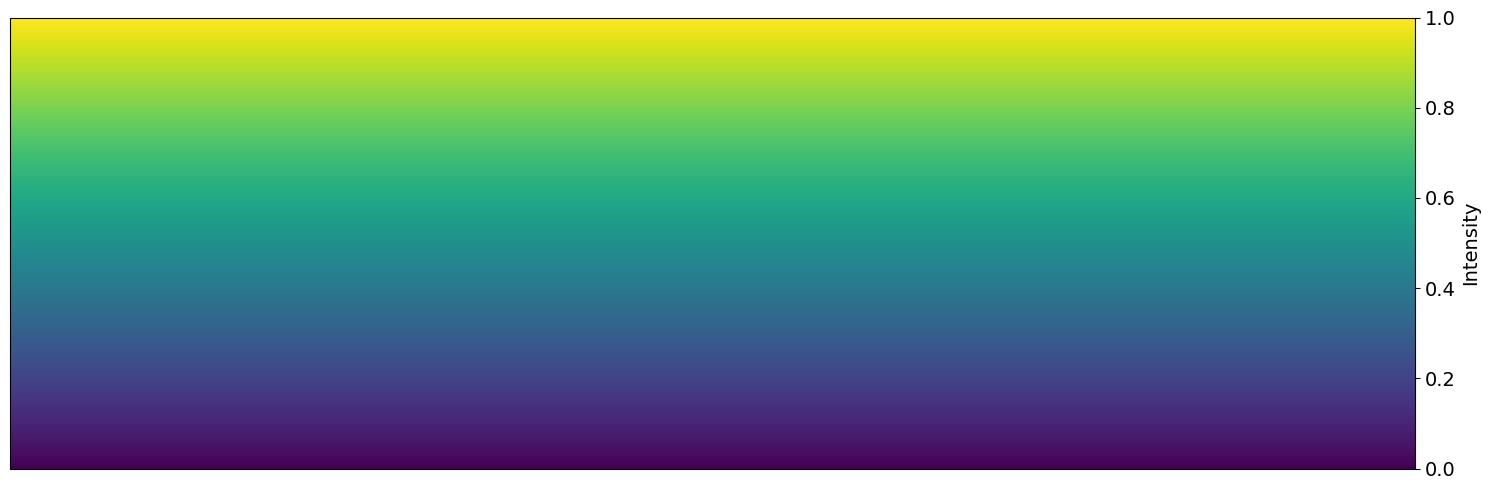

----------------------------------------------------
writer8181
----------------------------------------------------
/content/Datasets for Interpretation copy/CERUG/writer8181/Writer8181_03-01-line-1-n-3-y-163-x-839-h-105-w-301.png
/content/Datasets for Interpretation copy/CERUG/writer8181/Writer8181_03-02-line-0-n-2-y-98-x-444-h-109-w-255.png


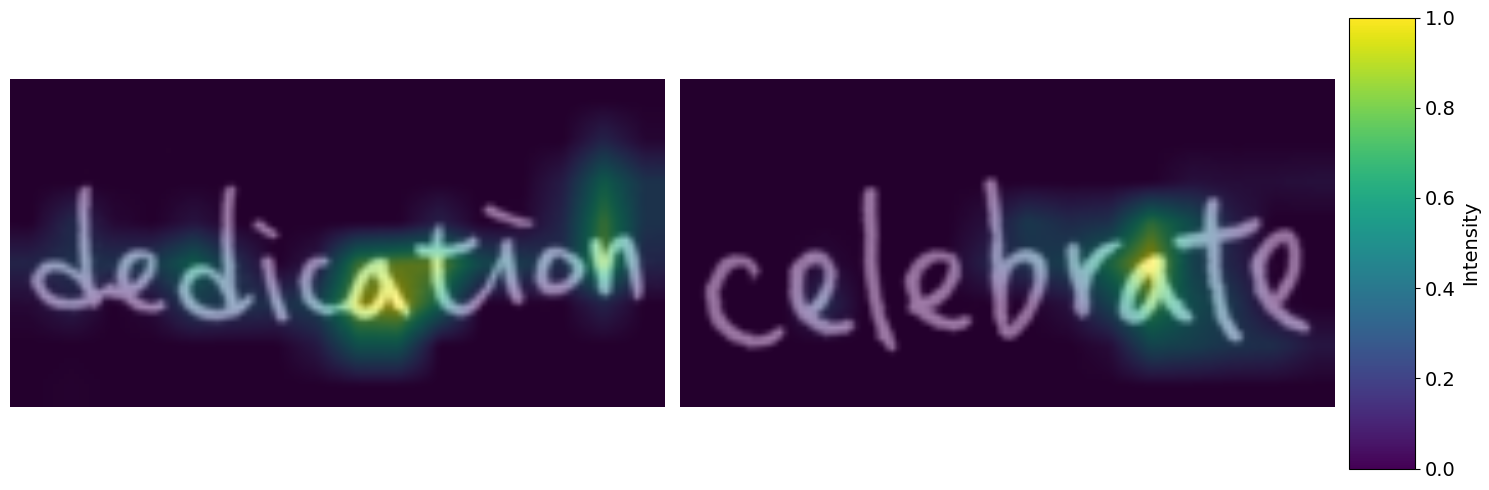

In [ ]:
path = "/content/Datasets for Interpretation copy/CERUG"


for folder_name in os.listdir(path):
    if folder_name != '.DS_Store':
        folder_path = os.path.join(path, folder_name)
        print("----------------------------------------------------")
        print(folder_name)
        print("----------------------------------------------------")


        visualizations = []

        for filename in os.listdir(folder_path):
            filepath = os.path.join(folder_path, filename)
            if os.path.isfile(filepath) and filepath.endswith('.png'):
                image = Image.open(filepath).convert('L')
                image = resizing(image)
                image = image / 255.0

                rgb_img = np.stack((image, image, image), axis=-1)
                img_tensor = transform()(image)
                img_tensor = img_tensor.float()

                cam = GradCAM(model=model_CERUG, target_layers=target_layers)
                grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=None)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
                visualizations.append(visualization)
                print(filepath)


        num_images = len(visualizations)
        fig = plt.figure(figsize=(15, 5))
        gs = gridspec.GridSpec(1, num_images + 1, width_ratios=[1] * num_images + [0.1])


        for i, vis in enumerate(visualizations):
            ax = fig.add_subplot(gs[i])
            im = ax.imshow(vis, interpolation='bilinear')
            ax.axis('off')
            im.set_clim(0, 1)


        ax_cbar = fig.add_subplot(gs[-1])
        cbar = plt.colorbar(im, cax=ax_cbar, pad=0.1)
        cbar.ax.set_ylabel('Intensity', fontsize=14)

        cbar.ax.tick_params(labelsize=14)

        plt.subplots_adjust(wspace=0.3)

        plt.tight_layout()
        plt.savefig(f"{folder_name}_visualization.svg", format='svg', dpi=300, bbox_inches='tight')

        plt.show()
